<a href="https://colab.research.google.com/github/justincharney/CIFAR10-Image-Recongition/blob/main/CIFAR_10_Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing the required libraries and packages
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable



In [2]:
# downloading dataset from the torchvision module to create testing and training sets

train_set = datasets.CIFAR10("data", download=True, transform= 
                             transforms.Compose([transforms.ToTensor(),
                                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
test_set = datasets.CIFAR10("data", download=True, train=False, transform=
                            transforms.Compose([transforms.ToTensor(),
                                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [3]:
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)


In [4]:
# method to return name of class from label
def output_label(label):
  output_mapping = {
      0: "airplane",
      1: "automobile",
      2: "bird",
      3: "cat",
      4: "deer",
      5: "dog",
      6: "frog",
      7: "horse",
      8: "ship",
      9: "truck"
      }
  input = (label.item() if type(label) == torch.Tensor else label)

  return output_mapping[input]

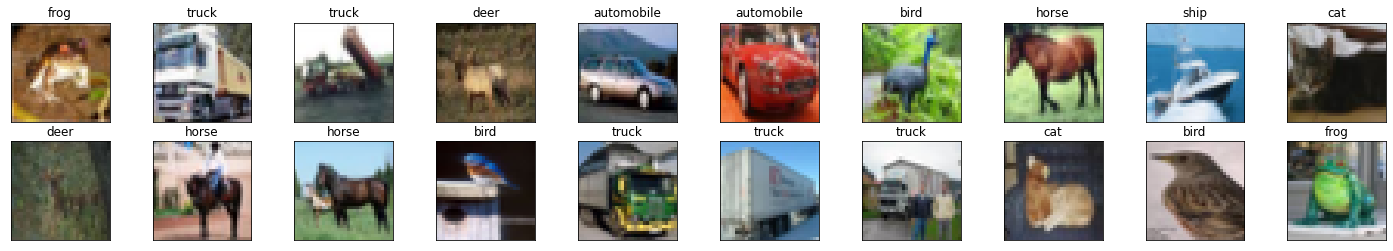

In [5]:
# explore the data

#image classes
classes = classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# helper function to unnormalize and display image
def imshow(img):
  img = img/2 + 0.5 #unnormalize image
  plt.imshow(np.transpose(img, (1,2,0))) #convert from Tensor

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])



In [6]:
# build the CNN


class CIFAR10CNN(nn.Module): 
  def __init__(self):
    super(CIFAR10CNN, self).__init__()

    #takes in 32x32x3 image tensor
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3,
                  padding = 1), #outputs 32x32x32,
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
        #outputs 16x16x32
    )
    #takes in 16x16x32
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels= 32, out_channels=64, kernel_size=3), #outputs 14x14x64
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
        #outputs 7x7x64
    )

    self.fc1 = nn.Linear(in_features=64*7*7, out_features =600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features = 120)
    self.fc3 = nn.Linear(in_features=120, out_features = 10)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1) #flatten image input
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)

    return out


In [7]:
# creating an instance of the model
model = CIFAR10CNN()

#defining loss function
criterion = nn.CrossEntropyLoss()

learning_rate = 1e-3
#defining optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [8]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 3, 32, 32])

In [11]:
# train the network

num_epochs = 5

count = 0

#lists to visualize loss and accuracy
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:

    train = Variable(images.view(100, 3, 32, 32))
    labels = Variable(labels)

    # forward pass
    outputs = model(train)
    loss = criterion(outputs, labels)

    #clear accumulated gradients
    optimizer.zero_grad()

    #backpropagation
    loss.backward()
    optimizer.step()
    count += 1

    #accuracy and loss data
    if count % 50 == 0:
      total = 0
      correct = 0

      for images, labels in test_loader:
        labels_list.append(labels)

        test = Variable(images.view(100, 3, 32, 32))

        outputs = model(test)

        predictions = torch.max(outputs, 1)[1]
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()

        total += len(labels)

      accuracy = correct*100/total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if count % 500 == 0:
      print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))



Iteration: 500, Loss: 0.9729741811752319, Accuracy: 67.73999786376953%
Iteration: 1000, Loss: 0.8554480075836182, Accuracy: 68.66000366210938%
Iteration: 1500, Loss: 0.8318467736244202, Accuracy: 69.05999755859375%
Iteration: 2000, Loss: 0.7996016144752502, Accuracy: 69.13999938964844%
Iteration: 2500, Loss: 0.7894279360771179, Accuracy: 69.8499984741211%


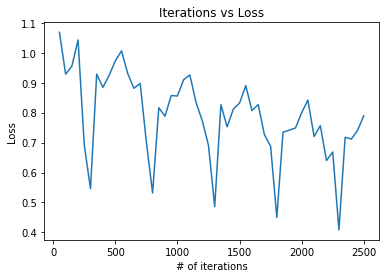

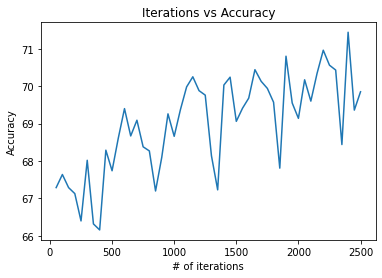

In [14]:
# loss and accuracy visualization

plt.plot(iteration_list, loss_list)
plt.xlabel("# of iterations")
plt.ylabel("Loss")
plt.title ("Iterations vs Loss")
plt.show()

plt.plot(iteration_list, accuracy_list)
plt.xlabel("# of iterations")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [16]:
# Looking at accuracy for each class

class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
  for images, labels in test_loader:
    test = Variable(images)
    outputs = model(test)
    predicted = torch.max(outputs,1)[1]
    correct = (predicted == labels).squeeze()

    for i in range(100):
      label = labels[1]
      class_correct[label] += correct[i].item()
      total_correct[label] += 1

for i in range(10):
  print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100/ total_correct[i]))

Accuracy of airplane: 71.14%
Accuracy of automobile: 71.12%
Accuracy of bird: 70.69%
Accuracy of cat: 69.10%
Accuracy of deer: 68.00%
Accuracy of dog: 68.00%
Accuracy of frog: 70.77%
Accuracy of horse: 67.20%
Accuracy of ship: 68.67%
Accuracy of truck: 69.50%


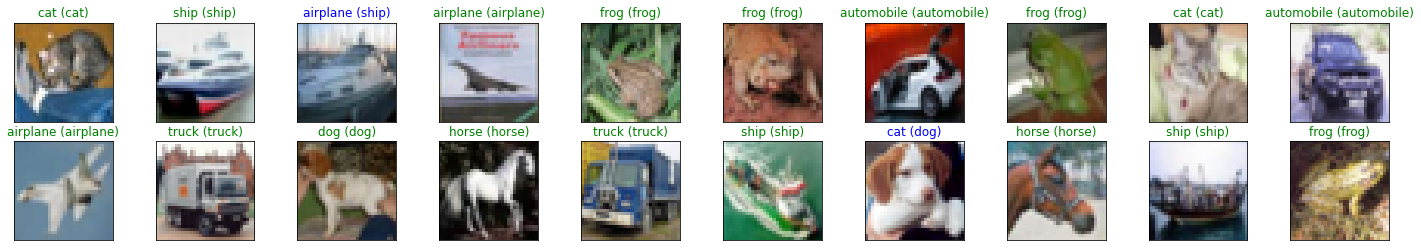

In [20]:
# visualize the results

#batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

output = model(images)

#convert model output to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) 

#plot images from batch with actual and predicted labels
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2,20/2, idx+1, xticks=[], yticks = [])
  imshow(images.cpu()[idx])
  ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]), 
               color = ("green" if preds[idx] == labels[idx].item() else "blue")
  )

